# Distance dependence analysis  
Studying how the coverage factor and volumes change as path length from the soma increases.

### Downloading data
Uncomment and run the cell below if you'd like to run the cells below

In [ ]:
#! bash downloadData.sh
#! bash downloadSkeletons.sh

In [1]:
# just getting past the weird Static TLS thing...
from meshparty import trimesh_io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lib import compartment, u, modelling, plot, coverage, skel

In [2]:
DISTDF_FILENAME = "data/mito_to_skel_v185.h5"
CLEANIDS_FILENAME = "data/clean_compartment_ids_v185.csv"

# Reading data

In [3]:
distdf = compartment.read_dist_df(DISTDF_FILENAME)
cleanids = u.read_ids(CLEANIDS_FILENAME)

# Coverage vs. distance to soma

In [4]:
covfactordf = coverage.compute_mitocovfactor(distdf, cleanids, binwidth=20, refine=False, shrink=False)

In [5]:
covfactordf.head()

,componentid,mitocovfactor,bin_center,nodelbl,disttoleaf,cellid
0,0,0.653445,150.0,2,0.000000,648518346349537297
1,71,0.274697,170.0,2,0.000000,648518346349537297
2,84,0.546212,150.0,2,1.144212,648518346349537297
3,282,0.792467,130.0,2,21.115633,648518346349537297
4,305,0.889037,130.0,2,17.887986,648518346349537297


Removing cells that touch the soma (largely somatic)

In [6]:
covfactordf = covfactordf[covfactordf.disttoleaf > 0]

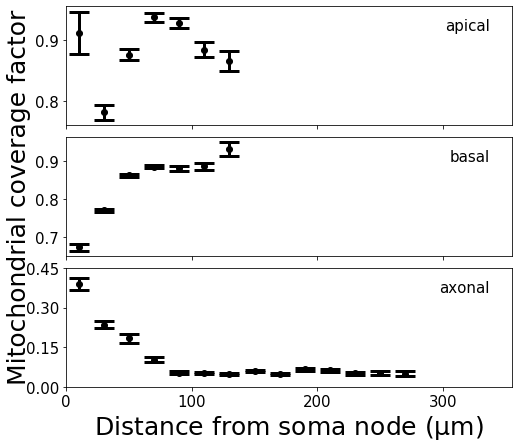

In [7]:
plot.extPanel4B(covfactordf, varname="mitocovfactor")

plt.show()

In [8]:
covfactordf[(covfactordf.bin_center == 130) &
            (covfactordf.nodelbl == 3)].\
            sort_values("mitocovfactor", ascending=False).head()

,componentid,mitocovfactor,bin_center,nodelbl,disttoleaf,cellid
9041,3123,1.149952,130.0,3,7.345349,648518346349536811
10504,2158,1.042548,130.0,3,23.312280,648518346349537075
2256,632,1.038933,130.0,3,1.034640,648518346349537492
11618,9843,1.008795,130.0,3,4.283157,648518346349536205
6384,1687,1.000000,130.0,3,4.887507,648518346349539934


# Volume vs. distance to soma

In [9]:
def add_disttoleaf(distdf, cellids):
    subdfs = list()
    
    for (i, cellid) in enumerate(cellids):
        print(f"#{i+1} of {len(cellids)}", end="\r")
        subdf = distdf[distdf.cellid == cellid].copy()
        cellskel = skel.read_neuron_skel(cellid)
        
        pls = skel.path_length_to_leaves(cellskel)
        subdf["disttoleaf"] = pls[subdf.nodeids.values] / 1000.  # scale to um
        
        subdfs.append(subdf)
        
    return pd.concat(subdfs)

In [10]:
distdf = add_disttoleaf(distdf, cleanids)

In [11]:
distdf.head()

,cellid,mitoids,mitovols,nodedists,nodeids,nodelbls,disttoleaf
1198207,648518346349537297,3392500,1487304,26566.162468,6658,2,47.954371
1198208,648518346349537297,3392500,1487304,29451.866936,6660,2,50.840076
1198209,648518346349537297,3392500,1487304,26687.582718,6661,2,48.075791
1198210,648518346349537297,3392500,1487304,28063.105118,6662,2,44.848946
1198211,648518346349537297,3392500,1487304,27921.338699,6663,2,44.990712


In [12]:
mindist = distdf.groupby("mitoids").min()[["disttoleaf", "nodedists"]]
meandisttosoma = distdf.groupby("mitoids").mean()[["nodedists", "mitovols"]]

Adding $\mathrm{\mu}$m$^3$ volume and majority vote compartment classification

In [13]:
meandisttosoma["vol"] = meandisttosoma["mitovols"] * plot.DEFAULT_VX_VOL
lbl_lookup = dict(zip(*compartment.majority_vote_label(distdf)))
meandisttosoma["nodelbl"] = [lbl_lookup[i] for i in meandisttosoma.index]

Removing mitos that cross into the soma

In [14]:
somatic = mindist.index[mindist.nodedists == 0].values
meandisttosoma = meandisttosoma.loc[~meandisttosoma.index.isin(somatic)]

Removing mitos whose distance to a leaf node is < 10$\mu$m

In [15]:
closetoleaf = mindist.index[mindist.disttoleaf < 30]
meandisttosoma_noleaf = meandisttosoma.loc[
                            ~meandisttosoma.index.isin(closetoleaf)]

In [16]:
meandist_fmt, _, _ = plot.format_distdf(meandisttosoma_noleaf, 30)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


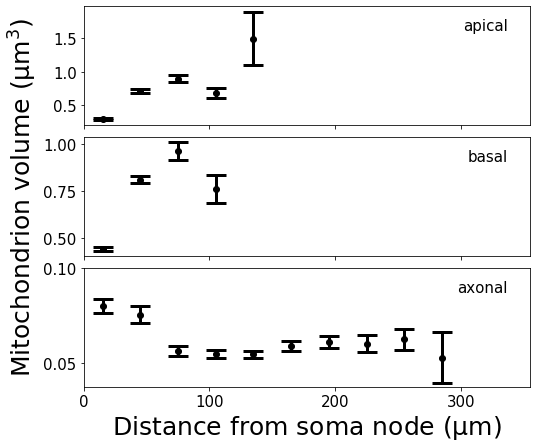

In [17]:
plot.extPanel4C(meandist_fmt)

plt.show()